# Explaining Models With shap

Jamison Hunter

# Imports

In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
# SkLearn Imports
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from lime.lime_tabular import LimeTabularExplainer
from matplotlib.colors import LinearSegmentedColormap
# Import shap and initialize javascript:
import shap
shap.initjs()
# ignore warnings
import warnings
warnings.filterwarnings("ignore")
# setting random state for reproducibility
SEED = 321
np.random.seed(SEED)

# Loading Previous Model

In [2]:
# setting the style for seaborn graphs
plt.style.use(['classic','seaborn-muted', 'seaborn-poster'])

In [3]:
def evaluate_regression(model, X_train,y_train, X_test, y_test): 
    """Evaluates a scikit learn regression model using r-squared and RMSE"""
    
    # Training Data
    y_pred_train = model.predict(X_train)
    r2_train = r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train)
    
    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")
        
    
    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test)
    
    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")

In [4]:
def get_importances(model, feature_names=None,name='Feature Importance',
                   sort=False, ascending=True):
    
    ## checking for feature names
    if feature_names == None:
        feature_names = model.feature_names_in_
        
    ## Saving the feature importances
    importances = pd.Series(model.feature_importances_, index= feature_names,
                           name=name)
    
    # sort importances
    if sort == True:
        importances = importances.sort_values(ascending=ascending)
        
    return importances

In [5]:
def plot_importance_color(importances, top_n=None,  figsize=(8,6), 
                          color_dict=None):
    
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## create plot with colors, if provided
    if color_dict is not None:
        ## Getting color list and saving to plot_kws
        colors = plot_vals.index.map(color_dict)
        ax = plot_vals.plot(kind='barh', figsize=figsize, color=colors)
        
    else:
        ## create plot without colors, if not provided
        ax = plot_vals.plot(kind='barh', figsize=figsize)
        
    # set titles and axis labels
    ax.set(xlabel='Importance', 
           ylabel='Feature Names', 
           title=title)
    
    ## return ax in case want to continue to update/modify figure
    return ax

In [6]:
loaded = joblib.load('random_forest_l01.joblib')
loaded.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'preprocessor', 'RandomForest'])

In [7]:
X_train_df = loaded['X_train']
y_train = loaded['y_train']
X_test_df = loaded['X_test']
y_test = loaded['y_test']
preprocessor = loaded['preprocessor']
loaded_model = loaded['RandomForest']

Training Data:	R^2= 0.94	RMSE= 182267.22
Test Data:	R^2= 0.56	RMSE= 1365988.18


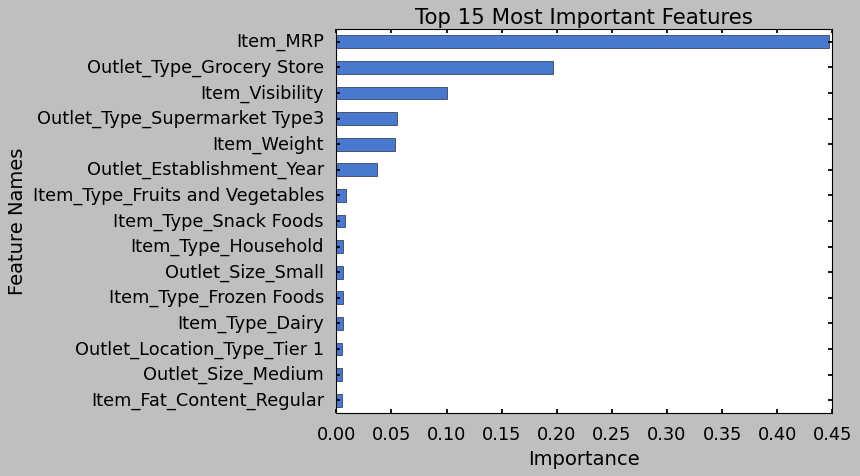

In [8]:
evaluate_regression(loaded_model,X_train_df, y_train, X_test_df,y_test)
loaded_importances = get_importances(loaded_model)
plot_importance_color(loaded_importances,top_n=15,color_dict=None);

# SHAP Explainer

In [9]:
len(X_train_df)

6392

In [10]:
X_shap = shap.sample(X_train_df,nsamples=400,random_state=SEED)
X_shap.head()

Item_Fat_Content_Low Fat  Item_Fat_Content_Regular  \
4469                       0.0                       1.0   
4438                       1.0                       0.0   
366                        0.0                       1.0   
2219                       1.0                       0.0   
6080                       1.0                       0.0   

      Item_Type_Baking Goods  Item_Type_Breads  Item_Type_Breakfast  \
4469                     0.0               1.0                  0.0   
4438                     0.0               0.0                  0.0   
366                      0.0               0.0                  0.0   
2219                     0.0               0.0                  0.0   
6080                     0.0               0.0                  0.0   

      Item_Type_Canned  Item_Type_Dairy  Item_Type_Frozen Foods  \
4469               0.0              0.0                     0.0   
4438               0.0              0.0                     0.0   
366                0.0              0.0                     0.0   
2219               0.0              0.0                     0.0   
6080               0.0              0.0                     0.0   

      Item_Type_Fruits and Vegetables  Item_Type_Hard Drinks  ...  \
4469                              0.0                    0.0  ...   
4438                              0.0                    0.0  ...   
366                               1.0                    0.0  ...   
2219                              0.0                    0.0  ...   
6080                              1.0                    0.0  ...   

      Outlet_Location_Type_Tier 2  Outlet_Location_Type_Tier 3  \
4469                          0.0                          1.0   
4438                          1.0                          0.0   
366                           1.0                          0.0   
2219                          0.0                          0.0   
6080                          0.0                          1.0   

      Outlet_Type_Grocery Store  Outlet_Type_Supermarket Type1  \
4469                        0.0                            1.0   
4438                        0.0                            1.0   
366                         0.0                            1.0   
2219                        0.0                            1.0   
6080                        1.0                            0.0   

      Outlet_Type_Supermarket Type2  Outlet_Type_Supermarket Type3  \
4469                            0.0                            0.0   
4438                            0.0                            0.0   
366                             0.0                            0.0   
2219                            0.0                            0.0   
6080                            0.0                            0.0   

      Item_Weight  Item_Visibility  Item_MRP  Outlet_Establishment_Year  
4469         7.72         0.074669   76.3986                     1987.0  
4438         5.11         0.034868  163.8210                     2004.0  
366          8.05         0.078386  256.4646                     2004.0  
2219         8.76         0.050131  128.3336                     1999.0  
6080         6.59         0.176748   82.7908                     1998.0  

[5 rows x 32 columns]

In [11]:
# getting the corresponding y-values
y_shap = y_train.loc[X_shap.index]
y_shap 

4469    1402.1748
4438    2120.5730
366     5153.2920
2219    2556.6720
6080      83.8908
          ...    
215      131.1626
4680    2251.0698
1288    1834.9448
3635     759.0120
7936    4074.6960
Name: Item_Outlet_Sales, Length: 400, dtype: float64

In [12]:
explainer = shap.Explainer(loaded_model)
explainer

In [13]:
# Getting the shap values
shap_values = explainer(X_shap,y_shap)
type(shap_values)

shap._explanation.Explanation

In [14]:
shap_values[0]

.values =
array([ 1.20968119e+01,  5.50340001e+00, -3.62701696e+00,  1.98310906e+01,
        1.11523546e-01, -8.03330197e+00, -1.52301266e+00,  1.85767266e-01,
       -1.42821506e+00, -3.63482799e-02,  1.34597946e+00,  3.25532203e+00,
        2.12039124e-01, -7.46750604e-01, -3.83214222e-01, -1.21910718e+00,
       -8.33172811e-01, -1.25616031e+00, -2.54346395e-01,  6.49020426e+00,
       -5.36520397e+00, -4.59014426e+00, -1.66094701e+01, -3.00466304e+01,
        2.06848580e+02,  7.66997854e-01,  5.58476124e+00, -7.90927011e+01,
        5.96077057e+01,  2.90301317e+01, -9.62973749e+02, -7.30884818e+01])

.base_values =
array([2154.71233664])

.data =
array([0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 1.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
      

In [15]:
shap_values.shape

(400, 32)

In [16]:
# slicing for failing values 
shap_vals_1 = shap_values[:,:]
shap_vals_1.shape

(400, 32)

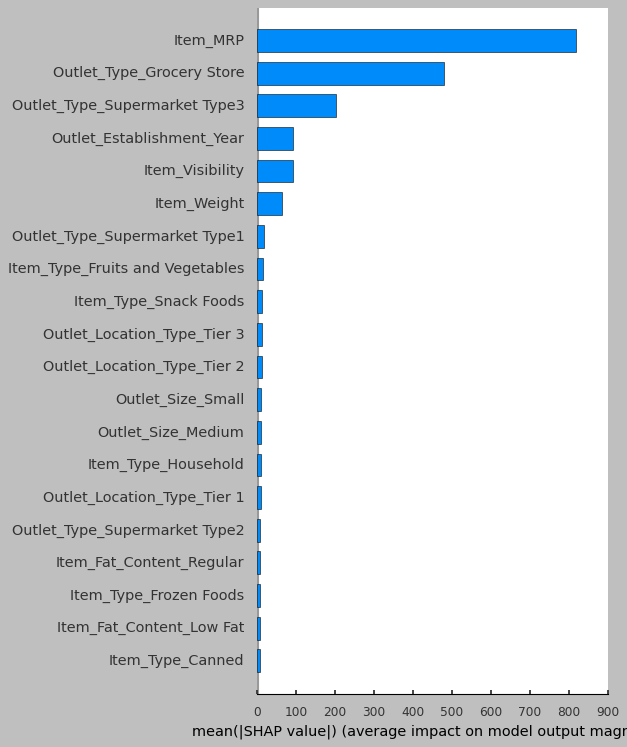

In [17]:
shap.summary_plot(shap_vals_1,features= X_shap, plot_type='bar')

The item importances between the saved random forest model and SHAP are overall quite similar but do have certain distinctions.Item MRP and grocery store are both the top two features. Supermarket type 3 and visibility are both in the lesser three out of the top five but are in different places. There are other feature importances such as item weight, which may appear in one list's top 5 importances but not the other's. These features seem to still be of importance for each method of measurement but certainly not of equal importance for both.

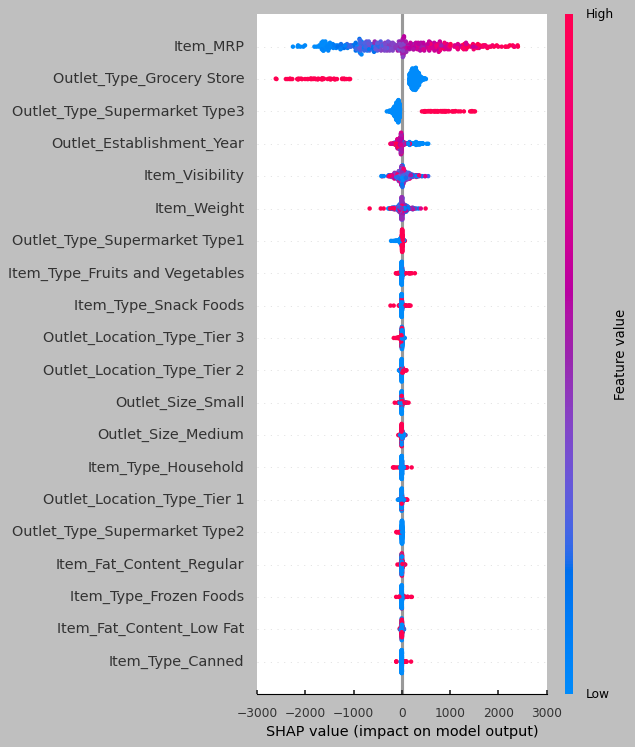

In [18]:
shap.summary_plot(shap_vals_1,features= X_shap, plot_type='dot')

According to the above SHAP graph, Item MRP has a profound impact on product sales, which is a fairly obvious observation. Though, the more specific interpretation is that a lower price will generally lead to a higher number of sales. We can also see that if the outlet is a grocery store, there will be a significant decrease in product sales. If the outlet is a type 3 supermarket; however, there will be a marked increase in product sales.

# Local Explanations

In [19]:
X_shap_local = X_shap.reset_index(drop=True)
y_shap_local = y_shap.reset_index(drop=True)

In [20]:
# Getting the shap values wth the local X_shap 
shap_values = explainer(X_shap_local,y_shap_local)
shap_vals_1 = shap_values[:,:]

In [21]:
y_pred = loaded_model.predict(X_shap_local)
y_pred = pd.Series(y_pred, index=X_shap_local.index, name='Predicted')
y_pred

0      1314.475624
1      2395.122288
2      5257.196748
3      2161.359908
4       113.785220
          ...     
395     165.451300
396    1911.125636
397    2232.360820
398     683.916418
399    3834.209040
Name: Predicted, Length: 400, dtype: float64

<AxesSubplot: xlabel='Item_MRP', ylabel='Count'>

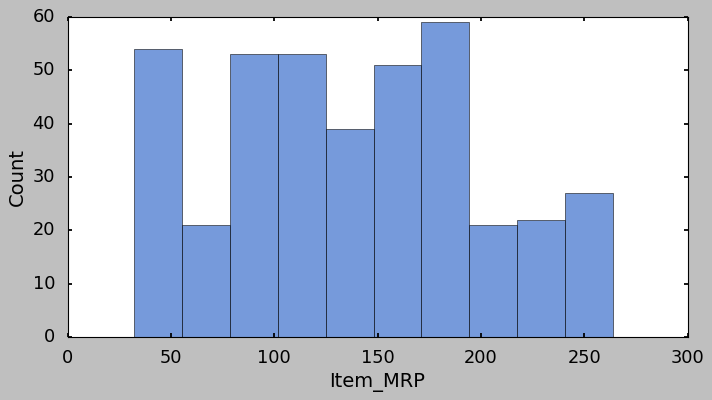

In [22]:
# creating a histogram plot of local item MRP
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(X_shap_local['Item_MRP'])

In [23]:
lime_explainer =LimeTabularExplainer(training_data=X_shap.values, feature_names=X_shap.columns, mode='regression')
lime_explainer

# Maximum Item MRP

In [24]:
row = X_shap_local["Item_MRP"].max()
X_shap_local[X_shap_local["Item_MRP"] == row]

Item_Fat_Content_Low Fat  Item_Fat_Content_Regular  \
366                       1.0                       0.0   

     Item_Type_Baking Goods  Item_Type_Breads  Item_Type_Breakfast  \
366                     0.0               0.0                  0.0   

     Item_Type_Canned  Item_Type_Dairy  Item_Type_Frozen Foods  \
366               0.0              1.0                     0.0   

     Item_Type_Fruits and Vegetables  Item_Type_Hard Drinks  ...  \
366                              0.0                    0.0  ...   

     Outlet_Location_Type_Tier 2  Outlet_Location_Type_Tier 3  \
366                          0.0                          1.0   

     Outlet_Type_Grocery Store  Outlet_Type_Supermarket Type1  \
366                        0.0                            1.0   

     Outlet_Type_Supermarket Type2  Outlet_Type_Supermarket Type3  \
366                            0.0                            0.0   

     Item_Weight  Item_Visibility  Item_MRP  Outlet_Establishment_Year  
366         13.8         0.141235  263.7884                     1987.0  

[1 rows x 32 columns]

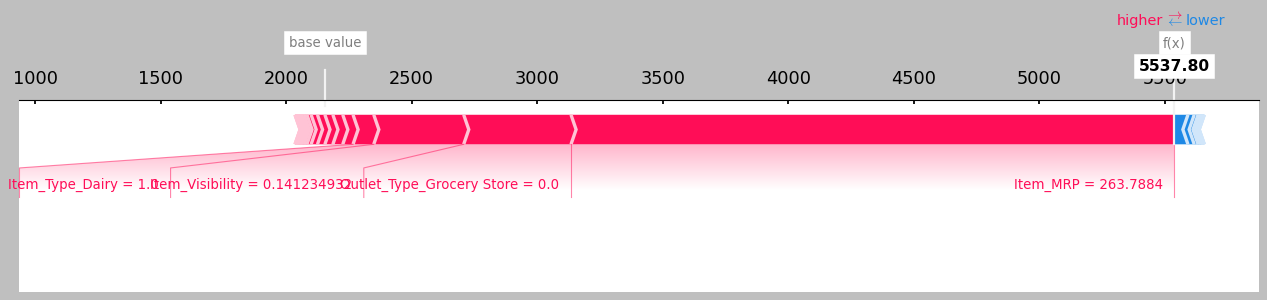

In [45]:
shap.force_plot(explainer.expected_value[:],
                shap_values=shap_vals_1[366].values,
               features=X_shap_local.iloc[366], matplotlib=True)

In [26]:
exp = lime_explainer.explain_instance(X_shap.iloc[366],
                               loaded_model.predict)
exp.show_in_notebook()

The 3 most influential features are the store being a grocery store, the item's MRP and being a type 3 supermarket. The prediction is affected positively by the grocery store and item MRP features while it is affected negatively by being a type 3 supermarket.

# Minimum Item MRP

In [27]:
row = X_shap_local["Item_MRP"].min()
X_shap_local[X_shap_local["Item_MRP"] == row]

Item_Fat_Content_Low Fat  Item_Fat_Content_Regular  \
305                       0.0                       1.0   

     Item_Type_Baking Goods  Item_Type_Breads  Item_Type_Breakfast  \
305                     0.0               0.0                  0.0   

     Item_Type_Canned  Item_Type_Dairy  Item_Type_Frozen Foods  \
305               0.0              0.0                     0.0   

     Item_Type_Fruits and Vegetables  Item_Type_Hard Drinks  ...  \
305                              0.0                    0.0  ...   

     Outlet_Location_Type_Tier 2  Outlet_Location_Type_Tier 3  \
305                          0.0                          1.0   

     Outlet_Type_Grocery Store  Outlet_Type_Supermarket Type1  \
305                        0.0                            1.0   

     Outlet_Type_Supermarket Type2  Outlet_Type_Supermarket Type3  \
305                            0.0                            0.0   

     Item_Weight  Item_Visibility  Item_MRP  Outlet_Establishment_Year  
305         11.8         0.076657   32.3558                     1987.0  

[1 rows x 32 columns]

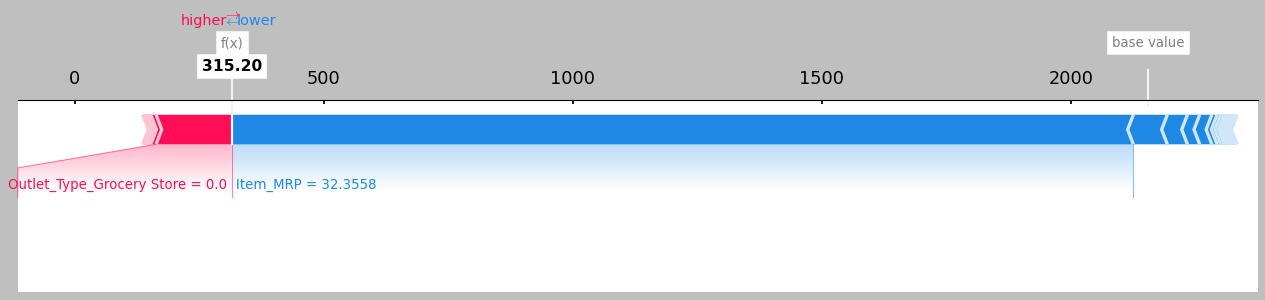

In [44]:
shap.force_plot(explainer.expected_value[:],
                shap_values=shap_vals_1[305].values,
               features=X_shap_local.iloc[305], matplotlib=True)

In [47]:
exp = lime_explainer.explain_instance(X_shap.iloc[305],
                               loaded_model.predict)
exp.show_in_notebook()

Once again, being a grocery store affected the prediction the most in the positive direction. However, item MRP and supermarket type 3 predict negatively. 

# Maximum Outlet Sales

In [30]:
row = pd.DataFrame(y_shap_local)["Item_Outlet_Sales"].max()
pd.DataFrame(y_shap_local)[pd.DataFrame(y_shap_local)["Item_Outlet_Sales"] == row]

Item_Outlet_Sales
385          8323.8316

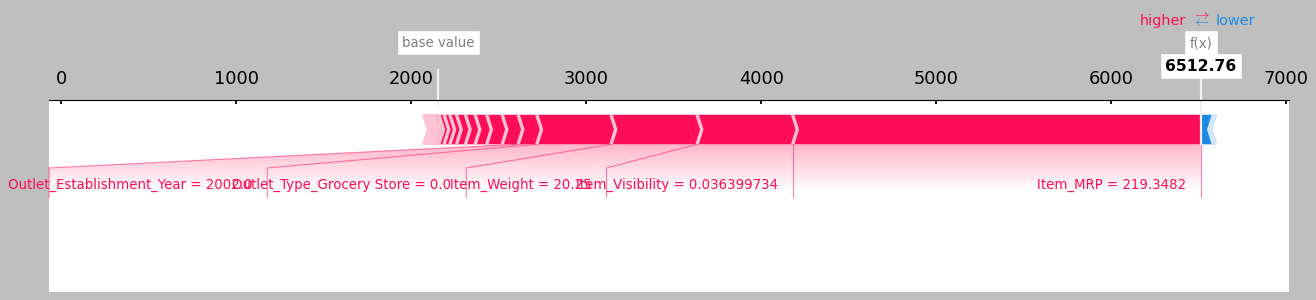

In [43]:
shap.force_plot(explainer.expected_value[:],
                shap_values=shap_vals_1[385].values,
               features=X_shap_local.iloc[385], matplotlib=True)

In [32]:
exp = lime_explainer.explain_instance(X_shap.iloc[385],
                               loaded_model.predict)
exp.show_in_notebook()

The graph above is representative of the row with the highest outlet sales. We can see that grocery store and item MRP are the two highest positive determiners of high outlet sales. Meanwhile, it can again be seen that a type 3 supermarket is a negative factor.

# Minimum Outlet Sales

In [33]:
row = pd.DataFrame(y_shap_local)["Item_Outlet_Sales"].min()
pd.DataFrame(y_shap_local)[pd.DataFrame(y_shap_local)["Item_Outlet_Sales"] == row]

Item_Outlet_Sales
178             36.619

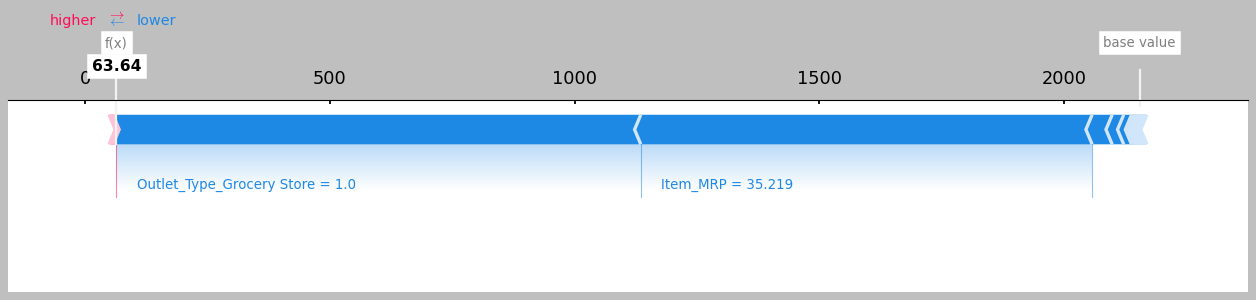

In [39]:
shap.force_plot(explainer.expected_value[:],
                shap_values=shap_vals_1[178].values,
               features=X_shap_local.iloc[178], matplotlib=True)

In [52]:
exp = lime_explainer.explain_instance(X_shap.iloc[178],
                               loaded_model.predict)
exp.show_in_notebook()

AttributeError: 'NoneType' object has no attribute 'set_title'

The lowest outlet sales is represented above. The outlet being a grocery store, item MRP, and type 3 supermarket are all negative factors in predicting low sales.